# File imports 

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import datetime as dt
import time
import json

sql = SQLContext(sc)

# Load data

In [2]:
def get_data(hrs):
    time_now = dt.datetime.now()
    hour_ago = time_now - dt.timedelta(hours=hrs)
    #print(time_now,hour_ago)

    end_time = time.mktime(time_now.timetuple())
    start_time = time.mktime(hour_ago.timetuple())
    #print(start_time,end_time)
    
    return sqlContext.read.load(format = "au.com.d2dcrc.carbon.spark.tweets", startTimestamp = int(start_time), endTimestamp = int(end_time))


# Most common hashtags

In [4]:
def get_tweets(df):
    #return rows from dadtframe
    return df.map(lambda row: row.data)

In [5]:
def get_jason(data):
    #returns a pyspark.rdd.PipelinedRDD of jason data
    return data.map(lambda data: json.loads(data))

In [6]:
def get_tweet_body(data):
    #returns a pyspark.rdd.PipelinedRDD of tweet bodies
    tweet_bodies = data.map(lambda tweet_as_json: tweet_as_json.get('body'))
    return tweet_bodies 

In [7]:
#This function obtains geo tag details from json tweets
#input: json data
#output: returns a pyspark.rdd.PipelinedRDD of tweet bodies
def get_tweet_geo(data):
    tweet_geo = data.map(lambda tweet_as_json: tweet_as_json.get('geo',"none"))
    return tweet_geo

In [8]:
def get_tweet_BodyLocation(data):
    bodys_with_location = data.filter(lambda line: 'location' in line).map(lambda line: (line.get('location', "none"),line.get('body',"none")))
    return bodys_with_location

In [23]:
def get_hashtags(jdata):
    hash_tags = jdata.flatMap(lambda line: line.split(" ")).filter(lambda word: word.startswith('#'))
    return hash_tags 

In [37]:
def hashtag_counter(htags):
    hashtag_counts = htags.map(lambda hashtag: (hashtag, 1)).reduceByKey(lambda a, b: a + b)
    return hashtag_counts

In [52]:
#this fuction returns a given number of common hashtags
#inputs: list of hashtags or hashtag counter dictionary
#output: list of common hashtags 
def common_hashtags(htags,n):
    return Counter(dict(htags)).most_common(n)

In [55]:
#this fuction takes a dictionary and plots key value pairs
def plot_bargraph(d):
    %matplotlib inline
    plt.bar(range(len(d)), d.values(), align="center")
    plt.xticks(range(len(d)), list(d.keys()),rotation='vertical')
    plt.show()

In [59]:
#pipeline operations

df = get_data(5) #get twitter data for a given number of minutes
test =get_tweets(df)
test= get_jason(test)
test= get_tweet_body(test)
hashTags = get_hashtags(test)
hashtag_counts = hashtag_counter(hashTags)

In [60]:
hashtag_count_list = hashtag_counts.take(200)

In [61]:
#Ten common hashtags 
common_10 = common_hashtags(hashtag_count_list,20) 
print(common_10)

[('#MTVStars', 58), ('#auspol', 46), ('#ALDUBBagongSimuLa', 20), ('#COP21', 9), ('#qld', 8), ('#Adelaide', 7), ('#paramedics', 5), ('#alat', 4), ('#Job', 4), ('#boats', 3), ('#freelance', 3), ('#amwriting', 3), ('#Shenhua', 3), ('#startup', 3), ('#Victoria', 3), ('#civilrightstwitter', 3), ('#clearancerate', 2), ('#KylieAfterDark', 2), ('#reading', 2), ('#Soils', 2)]


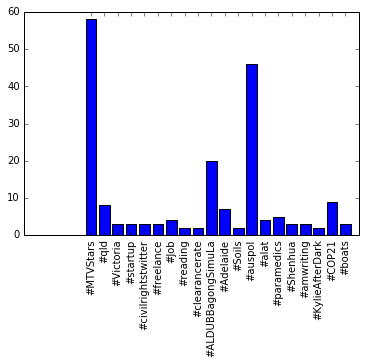

In [62]:
plot_bargraph(dict(common_10))

# Spark Dataframe

In [2]:
def get_data_hourly_frames(hr):
    smins = hr*60
    emins = (hr+1)*60
    now = int(time.time()) # take current time
    ehour_ago = now - (smins * 60)
    shour_ago = now - (emins * 60)
    # The call below creates the Spark DAG (Directed Acyclic Graph) on the cluster
    return sqlContext.read.load(format = "au.com.d2dcrc.carbon.spark.tweets", startTimestamp = shour_ago, endTimestamp = ehour_ago)

## Unique Hashtag,Location Pair Extract

In [3]:
#This function will extract the text of hashtag from gnip hashtag dictionary
#input: gnip hashtag dictionaries
#output: list of hashtag text
def extract_hashtag(hashtag_list):
    hashtags = list()
    
    for hashtag in hashtag_list:
        text = hashtag.get('text').lower()
        if text is not None:
            hashtags.append(text)
        
    return hashtags

#This function extracts the location and hashtag details for each tweet
#input: dataframe loaded from the server
#output: retuns a rdd containing location and hashtags for each location
def get_twitter_details(df):
    tweetTest = df.map(lambda row: row.data).map(lambda data: json.loads(data)).filter(lambda line: 'location' in line)\
    .map(lambda line: (line['location']['name'],line['twitter_entities']['hashtags']))\
    .map(lambda line_tuple: (line_tuple[0], extract_hashtag(line_tuple[1])))
    return tweetTest
#['country_code']

In [4]:
# creates a dataframe from extracted twitter details (location and hashtag)
#input: rdd with list of hashtags for each location  
#output: returns a spark dataframe for each hashtag with location
def create_sparkDF(rdd):
    sparkDF = sqlContext.createDataFrame(rdd,['location','hashtags'])
    sparkDF = sparkDF.select('location',explode(sparkDF.hashtags).alias("aHash"))
    return sparkDF

def top_10_hashes(loc,dataframe):
    dataframe.registerTempTable("hashtagTable")
    result = sqlContext.sql("SELECT location, anHash as hashtag, count(*) as count \
                            FROM eventTable \
                            GROUP BY location,anHash \
                            HAVING location='"+loc+"'\
                            ORDER BY count DESC \
                            LIMIT 10")
    return result

In [5]:
def top_10_hashes(loc,dataframe):
    dataframe.registerTempTable("hashtagTable")
    top10_for_location = sqlContext.sql("SELECT aHash as hashtag, count FROM \
                            (SELECT location, aHash,count(*) as count \
                            FROM hashtagTable GROUP BY location,aHash ORDER BY count DESC) as t \
                            WHERE t.location='"+loc+"' LIMIT 10")
    return top10_for_location

## Top 10 hashtags with location

In [13]:
def top10_hashtags(sparkdf):
    sparkdf.registerTempTable("eventTable")
    #sqlContext.sql("SELECT location, anHash AS 'Hash',COUNT(*) FROM eventTable GROUP BY location").show()
    top10DF = sqlContext.sql("SELECT location, aHash,count(*) as count FROM eventTable GROUP BY location,aHash ORDER BY count DESC LIMIT 10")
    return top10DF

In [8]:
#input: Number of hours tweetes are considered. 
#Will be considering tweets before n number of hours from current time
def hashtag_main(mins):
    df = get_data(mins)
    rddData = get_twitter_details(df)
    spDF = create_sparkDF(rddData)
    top10_spDF=top10_hashtags(spDF)
    top10_spDF.show()

In [8]:
hashtag_main(60)

+---------+--------------------+-----+
| location|              anHash|count|
+---------+--------------------+-----+
|   Sydney|              auspol|   15|
|   Sydney|          nowplaying|   13|
|     Ghan|              trndnl|   11|
|Melbourne|          victraffic|    8|
|Melbourne|        ForceAwakens|    7|
|   Sydney|              sydney|    7|
|Australia|              auspol|    6|
|Melbourne|StarWarsForceAwakens|    6|
|  Chicago|      BlackChristmas|    5|
|   Sydney|           ausunions|    5|
+---------+--------------------+-----+



In [7]:
hashtag_main(1440)

+---------+-------------------+-----+
| location|             anHash|count|
+---------+-------------------+-----+
|   Sydney|         nowplaying|  324|
|     Ghan|             trndnl|  269|
|   Sydney|             Sydney|  179|
| Pinjarra|EvasHolidayGiveaway|  138|
|   Sydney|  ALDUB5thMonthsary|  120|
|Melbourne|             auspol|  108|
|   Sydney|        sydneystorm|  104|
|   Sydney|             sydney|  103|
|Melbourne|               PTSD|   95|
|Melbourne|         Depression|   95|
+---------+-------------------+-----+



In [16]:
hashtag_main(1)

+----------+-------------------+-----+
|  location|              aHash|count|
+----------+-------------------+-----+
|  Brisbane|thevampstruthordare|  147|
|  Brisbane|     vampsdownunder|   35|
|  Longford|             auspol|   18|
|    Sydney|         nowplaying|   17|
| Melbourne|           equation|   14|
|      Ghan|             trndnl|   11|
|    Sydney|             auspol|   11|
| Melbourne|                gms|   10|
|  Brisbane|           blueroom|   10|
|Queensland|             auspol|    9|
+----------+-------------------+-----+



In [17]:
hashtag_main(2)

+----------+-------------------+-----+
|  location|              aHash|count|
+----------+-------------------+-----+
|  Brisbane|thevampstruthordare|  180|
|  Brisbane|     vampsdownunder|   38|
|    Sydney|         nowplaying|   31|
| Melbourne|       wrongonelive|   25|
|      Ghan|             trndnl|   24|
|  Longford|             auspol|   18|
|    Sydney|             auspol|   16|
|    Sydney|             sydney|   15|
|Queensland|             auspol|   14|
| Melbourne|           equation|   14|
+----------+-------------------+-----+



## Top 10 hashtags per location for the past hour or ...

In [18]:
#inputs: number of minutes considered from now and the city
#output: plots a bar graph showing the top 10 hashtags for the given location and time period
def top10_perlocation(hr,city):
    df = get_data(hr) #load twitter data
    #hash_rdd = get_twitter_hash_location(df)
    hash_rdd = get_twitter_details(df)
    sparkdf = create_sparkDF(hash_rdd)
    top10_spark = top_10_hashes(city,sparkdf)
    top10_Panda = top10_spark.toPandas()
    %matplotlib inline
    top10_Panda.plot(x="hashtag",kind='barh',color='gray',title='Top 10 hashtags for '+city+' in past '+str(hr)+' hrs',legend=False)
    plt.xlabel("count")

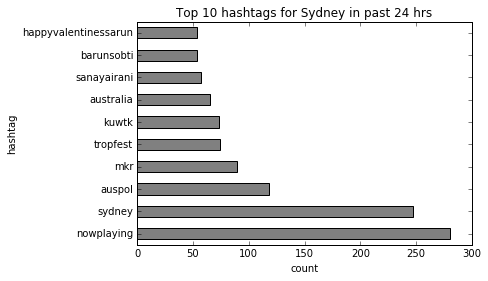

In [21]:
top10_perlocation(24,'Sydney') # top 10 hashtags in Sydney for the past 24 hours

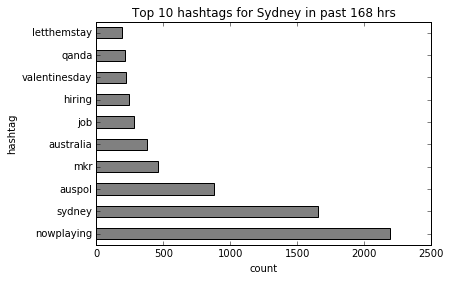

In [25]:
top10_perlocation(168,'Sydney') # top 10 hashtags in Sydney for the past 168 hours (week)

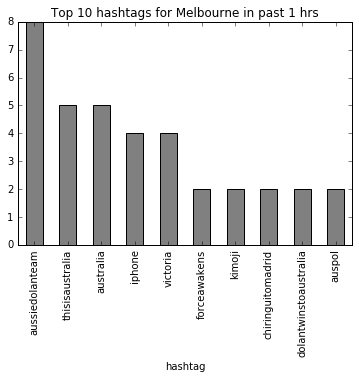

In [24]:
top10_perlocation(1,'Melbourne') # top 10 hashtags in Melbourne for the past hour

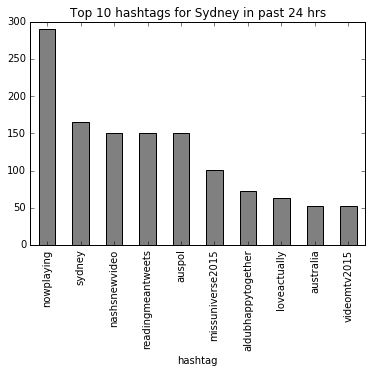

In [22]:
top10_perlocation(24,'Sydney') # top 10 hashtags in Sydney for the past 24 hours

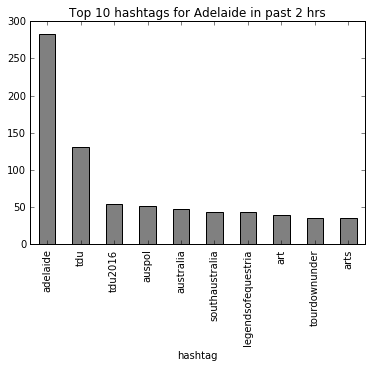

In [20]:
top10_perlocation(2,'Adelaide')

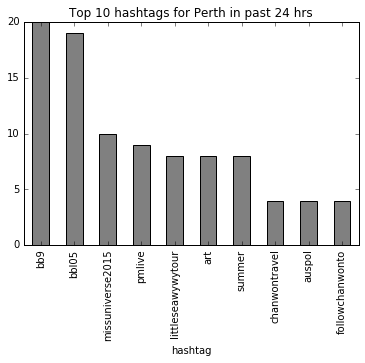

In [21]:
top10_perlocation(24,'Perth')

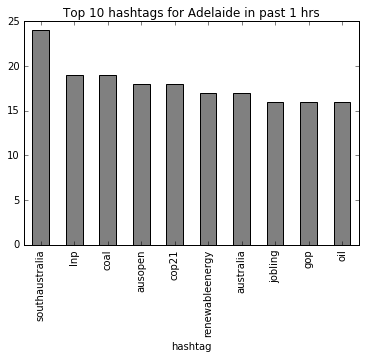

In [19]:
top10_perlocation(1,'Adelaide')

## Plot top10 hashetags for the past hours

In [6]:
def top10_perLocation(city):
    
    dflist = list()
    for i in range(0,5):
        df = get_data_hourly_frames(i)
        RDD = get_twitter_details(df)
        spdataframe = create_sparkDF(RDD)
        top10_spark = top_10_hashes(city,spdataframe)
        top10_Panda = top10_spark.toPandas()
        dflist.append(top10_Panda)
    return dflist

In [7]:
def pandas_top1o_hashtags(pandaslist):
    #pandaslist = top10_perLocation(city)
    finalP = pd.DataFrame()
    for i in range(len(pandaslist)):
        pandaslist[i]['timeframe'] =5-i
        finalP = finalP.append(pandaslist[i],ignore_index=True)
    return finalP

In [8]:
def plot_top10_hashtags(PandaDF,city):
    %matplotlib inline
    fig, ax = plt.subplots()

    grouped = PandaDF.groupby('hashtag')

    colors = iter(cm.rainbow(np.linspace(0, 1, len(grouped))))

    for key, group in grouped:
        group.plot(ax=ax, marker='o', x='timeframe', y='count',label=key,color=next(colors),title='Top 10 hashtags for '+city,legend=False)
        #kind='scatter'
    #ax.legend(loc='upper right',ncol=3,fontsize=8,numpoints=1)
    ax.legend(loc='upper center',bbox_to_anchor=(0.5,-0.1),ncol=3,fontsize=8,numpoints=1)

    #for i, txt in enumerate(PandaDF['hashtag']):
        #ax.annotate(txt,xy=(PandaDF['timeframe'][i],PandaDF['count'][i]),xytext = (-10,5),textcoords = 'offset points',)
    
    plt.show()

In [9]:
def main_prog(city):
    top10List = top10_perLocation(city)
    toPandas = pandas_top1o_hashtags(top10List)
    plot_top10_hashtags(toPandas,city)

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.0, right=4.0
  'left=%s, right=%s') % (left, right))


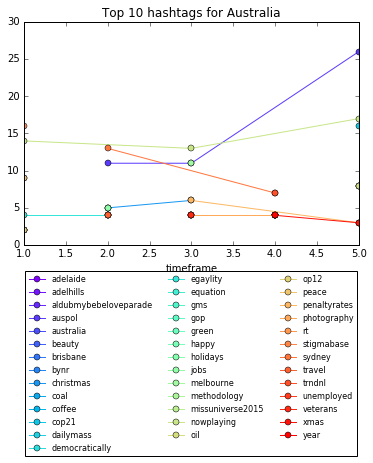

In [12]:
main_prog('Australia')

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2.0, right=2.0
  'left=%s, right=%s') % (left, right))


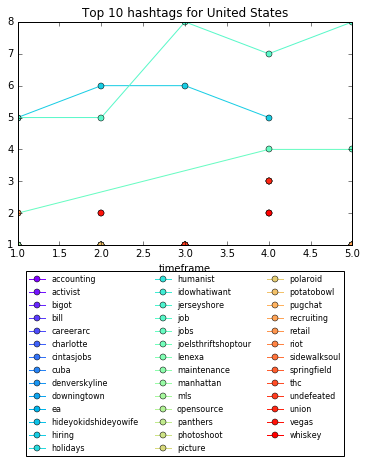

In [11]:
main_prog('United States')

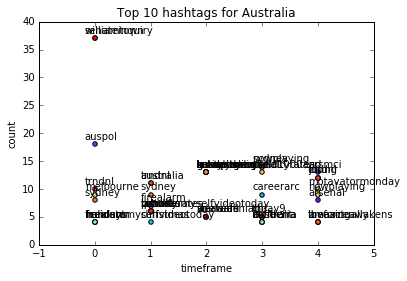

In [12]:
main_prog('Australia')

In [10]:
# tmieframe - shows the hourly timeframes from now
# each timeframe has the top 10 hastags for that frame
PandaDF 

,hashtag,count,timeframe
0,nowplaying,12,0
1,missuniverse2015,12,0
2,sydney,10,0
3,auspol,9,0
4,nswpol,2,0
5,sales,2,0
6,youtube,2,0
7,peoplewhomademy2015,2,0
8,theforceawakens,2,0
9,music,2,0
